# Compute on GPU: Cupy Vectors and Operators

@Author: Francesco Picetti - francesco.picetti@polimi.it

In this notebook we will show how to define a new `vector` class based on [Cupy](https://cupy.chainer.org/) operations.

First we need to install `cupy` properly. See its [guide](https://docs.cupy.dev/en/stable/install.html).

In [1]:
# !conda install -c rapidsai -c nvidia -c numba -c conda-forge cusignal cudatoolkit=10.2

#### Import modules

In [2]:
# Importing necessary modules
import numpy as np
import occamypy
from occamypy import cupy as occupy

# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':False
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


## 2D Phantom Deconvolution

In this example we reconstruct a phantom CT image starting from a blurred acquisition.
Again, we regularize the inversion by imposing the first derivative to be sparse.

**Note**: as the vector is instantiated on a GPU, we use the method `plot` for getting a plottable array

In [3]:
x = occupy.VectorCupy(np.load('./data/shepp_logan_phantom.npy', allow_pickle=True).astype(np.float32),
                     device=0).scale(1 / 255.)

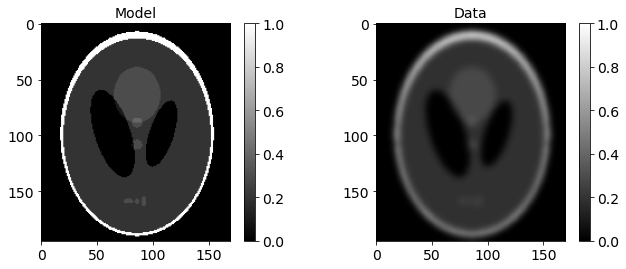

In [4]:
G = occupy.operator.GaussianFilter(x, [3, 3])
d = G * x

plt.figure(figsize=(11, 4))
plt.subplot(121), plt.title('Model')
plt.imshow(x.plot(), cmap='gray', vmin=0, vmax=1), plt.colorbar()
plt.subplot(122), plt.title('Data')
plt.imshow(d.plot(), cmap='gray', vmin=0, vmax=1), plt.colorbar()
plt.show()

As regularizer, we compute the gradient. If you need some signal processing operations, check out [cuSIGNAL](https://github.com/rapidsai/cusignal).

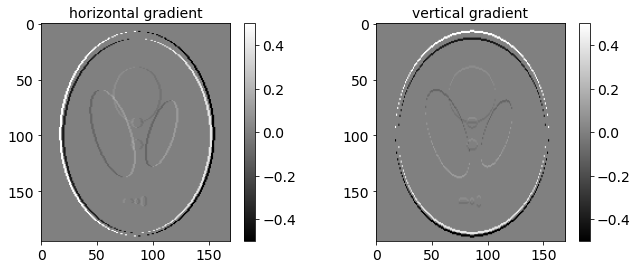

In [5]:
D = occupy.operator.Gradient(x)
Dx = D*x

plt.figure(figsize=(11, 4))
plt.subplot(121), plt.title('horizontal gradient')
plt.imshow(Dx.vecs[1].plot(), cmap='gray'), plt.colorbar()
plt.subplot(122), plt.title('vertical gradient')
plt.imshow(Dx.vecs[0].plot(), cmap='gray'), plt.colorbar()
plt.show()

Problem and solver:

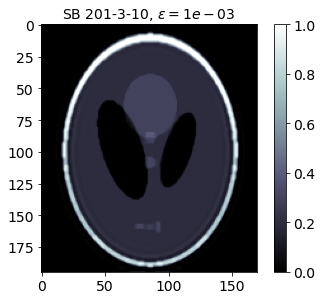

In [7]:
its = "%d-%d-%d" % (len(SB.obj), SB.niter_inner, SB.niter_solver)

plt.figure(figsize=(5, 4))
plt.imshow(problemSB.model.plot(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.tight_layout(pad=.5)

plt.title(r'SB %s, $\varepsilon=%.e$' % (its, problemSB.eps))
plt.show()

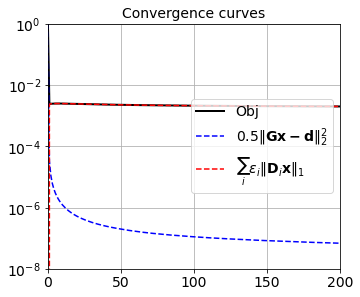

In [8]:
plt.figure(figsize=(5, 4))
plt.semilogy(SB.obj / SB.obj[0], 'k', lw=2, label='Obj')
plt.semilogy(SB.obj_terms[:, 0] / SB.obj[0], 'b--', label=r"$0.5 \Vert \mathbf{Gx-d} \Vert_2^2$")
plt.semilogy(SB.obj_terms[:, 1] / SB.obj[0], 'r--', label=r"$\sum_i\varepsilon_i \Vert \mathbf{D}_i\mathbf{x}\Vert_1$")
plt.legend(loc='right'), plt.grid(True)
plt.xlim(0, 200), plt.ylim(1e-8,1)
plt.tight_layout(pad=.5)

plt.title('Convergence curves')
plt.show()